<a href="https://colab.research.google.com/github/JiaxinLi-lipluszn/Temp_notebooks/blob/main/Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 

In [4]:
import os
import sys
import argparse

import torch
from torch import nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms as pth_transforms
from torchvision import models as torchvision_models
import pandas as pd
from torch.utils.data import Dataset
from functools import partial
import numpy as np
from torch import optim
from pathlib import Path
from torch.autograd import Variable

import os
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
import math
from functools import partial

import torch
import torch.nn as nn

from utils import trunc_normal_

import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

# Import utils

In [2]:
os.chdir("/content/drive/MyDrive/scRNA/128+128_10subsets")

In [3]:
import utils
import vision_transformer as vits_new

# Set paths

In [32]:
data_path = "/content/drive/MyDrive/scRNA/pseudo_data/train"

# Helpers

## Plot gradient

In [6]:
# To visualize the gradient flow
from matplotlib import pyplot as plt
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

# Load data

In [11]:
class scRNACSV(Dataset):
  def __init__(self, expression_matrix_path, perturb_list, transform = None, target_transform=None):
    self.expr = pd.DataFrame()
    self.samples = []
    self.labels = []
    for number_lab, label in zip(range(len(perturb_list)),perturb_list):
      path = expression_matrix_path + "/" + label + ".csv"
      df = pd.read_csv(path, index_col = 0)
      self.expr = pd.merge(self.expr, df, how = "outer", left_index = True, right_index = True)
      self.samples = self.samples + list(df.columns)
      lb = [number_lab for i in range(len(list(df.columns)))]
      self.labels = self.labels + lb
      print(f"This is label {label}, the number_lab is {number_lab}, there are {len(list(df.columns))} cells in this class")
    self.transform = transform
    self.target_transform = target_transform
    self.samples = [(self.samples[i],self.labels[i]) for i in range(len(self.labels))]
  def __len__(self):
    return self.expr.shape[1]

  def __getitem__(self,idx):
    one_cell = torch.from_numpy(np.array(self.expr.iloc[:,idx]))
    ret = self.transform(one_cell)
    return ret, self.labels[idx]
    #return one_cell, self.labels[idx]

## Augmentation

In [12]:
class DINO_Crop(object):
  def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
    self.global_crops_scale = global_crops_scale
    self.local_crops_scale = local_crops_scale
    self.local_crops_number = local_crops_number
    
  def __call__(self, x):
    inputs = []
    data = x  
    length = x.shape[0]
    
    global_size = int(length * self.global_crops_scale)
    global_index_1 = np.random.choice(length, size = global_size, replace = False)
    
    global_corr_1 = torch.from_numpy(global_index_1)
    
    global_data_1 = data[global_index_1,]
    global_input_1 = torch.cat([global_data_1, global_corr_1]).float()
    return global_input_1

In [13]:
perturb_list = ["A2M", "CCND1"]

In [31]:
perturb_list = ["0", "1"]

In [33]:
crop = DINO_Crop(1,0.25,8)

In [55]:
train_dataset = scRNACSV(data_path, perturb_list = perturb_list, transform = crop)

This is label 0, the number_lab is 0, there are 400 cells in this class
This is label 1, the number_lab is 1, there are 400 cells in this class


In [56]:
x, y = train_dataset[503]

In [57]:
x.shape

torch.Size([4000])

In [58]:
x

tensor([  1.,   1.,   1.,  ..., 788., 991., 923.])

In [19]:
y

1

In [37]:
#sampler = torch.utils.data.DistributedSampler(train_dataset, shuffle=True)
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle = True)

In [38]:
test_path = "/content/drive/MyDrive/scRNA/pseudo_data/test"

In [39]:
test_dataset = scRNACSV(test_path, perturb_list = perturb_list, transform = crop)

This is label 0, the number_lab is 0, there are 100 cells in this class
This is label 1, the number_lab is 1, there are 100 cells in this class


In [40]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = True)

In [30]:
for i, data in enumerate(train_loader, 0):
  inputs, labels = data
  print(inputs.shape)
  print(labels)
  break

torch.Size([16, 4000])
tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0])


# Prepare Model

In [50]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size=[224],in_chans=1, num_classes=2, embed_dim=129, mlp_ratio=4., depth = 1, qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
    super().__init__()

    # Number of features at the end of this module
    self.num_features = self.embed_dim = embed_dim # =3 in this golden truth modle
    
    # Initiate the [CLS] token and make it not learnable
    self.cls_token = nn.Parameter(torch.from_numpy(-1* np.ones((1,1,embed_dim)))).float()
    #self.cls_token = nn.Parameter(torch.from_numpy(np.array([[[0.0,-1.0,-1.0]]])).float())
    self.pos_drop = nn.Dropout(p=drop_rate)
    
    # Set SDG?
    #dpr = [x.item() for x in torch.linspace(0, drop_path_rate, 1)]  # stochastic depth decay rule
    
    # Set Norm layer
    self.norm = norm_layer(embed_dim)

    # Set the blk 
    dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
    self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads= 1, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
    # This head???
    self.head = nn.Linear(embed_dim, num_classes)
    self.Embedding = nn.Embedding(2000, 128)
    # SoftMax
    #self.softMax = F.log_softmax(10)
    #trunc_normal_(self.cls_token, std=.02)
    self.apply(self._init_weights) #???
    self.act = nn.LeakyReLU()
    self.exprProj = nn.Linear(1,1)
    
    

  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      trunc_normal_(m.weight, std=.02)
      if isinstance(m, nn.Linear) and m.bias is not None:
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
      nn.init.constant_(m.bias, 0)
      nn.init.constant_(m.weight, 1.0)

  def prepare_tokens(self, x):
    B, L = x.shape
    x = self.ReformatInput_cat(x)
    # add the [CLS] token to the embed patch tokens
    cls_tokens = self.cls_token.expand(B, -1, -1).cuda()
    x = torch.cat((cls_tokens, x), dim=1)
    # print(f"Here is the device of x {x.device}")
    #print(f"Here is the device of cls_tokens {cls_token.device}")
    return self.pos_drop(x)
  def ReformatInput_cat(self, x):
    # Split the index part and the expression data part
    # x dimension now B x G*2 (B is the batch size, G is the number of genes sampled)
    B, G_2 = x.shape
    G = int(G_2/2)
    expr, index = torch.split(x, (G,G), dim = 1)
    # expr and index are both B x G now
    #print(expr.shape)
    geneEmbedding = self.Embedding(index.int())
    #geneEmbedding = index.reshape(B, G, 1)
  
    # geneEmbedding is B x G x Embed_dim
    #print(geneEmbedding.shape)
    # Reshape the expr to add one dimension to match the geneEmbedding
    expr = expr.reshape(B, G, 1)
    #print("Here is the ")
    expr = self.exprProj(expr)
  
    # cat the expr and gene Embedding
    x = torch.cat((expr, geneEmbedding), dim = 2)
    # print(x.shape)
    return x
  def forward(self, x):
    #print(x.shape)
    B, L = x.shape
    x = self.prepare_tokens(x)
    #print(x.grad)
    #print("Here is the original data:")
    #print(x[0:3])
    for blk in self.blocks:
      x = blk(x)
    x = self.norm(x)
    #print("Here is the data before mean:")
    #print(x[0:3])
    #x = torch.mean(x, dim = 1).reshape(B,3)
    #print("Here is the output before the projection:")
    #print(x[0:3])
    # Use class token
    x = self.head(x[:,0])
    #print(x.shape)
    x = self.act(x)
    #x = self.head(x)
    #print(x.shape)
    #x = x.softmax(dim = -1)
    #print(x.grad)
    return x
  def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

  def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output

In [53]:
def vit_tiny(patch_size=16):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=129, depth=3, num_heads=1, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
    return model

## Block


In [47]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

## Attention

In [48]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

## MLP

In [49]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Train one Epoch

In [43]:
def train_one_epoch(trainloader, simple_model, epoch, optimizer):
  running_loss = 0.0
  simple_model.train()
  lossF = nn.CrossEntropyLoss()
  sum_loss = 0
  num = 0
  for batch_idx, (data, label) in enumerate(trainloader):
    data, label = Variable(data).cuda(), Variable(label).cuda()
    optimizer.zero_grad()
    output = simple_model(data)
    loss = lossF(output, label)
    sum_loss += loss
    num += 1
    loss.backward()
    optimizer.step()
    plot_grad_flow(simple_model.named_parameters())
    if batch_idx % 100 == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss {:.6f}".format(
                epoch, batch_idx*len(data), len(trainloader.dataset),
                100.*batch_idx/len(trainloader), loss.item()))
  loss_stat = (sum_loss/num).detach().cpu().numpy().item()
  log_stats = {**{f'Average Loss': loss_stat}, 'epoch': epoch + 1}
  with (Path(output_dir) / "loss.txt").open("a") as f: f.write(json.dumps(log_stats) + "\n")

# Train

In [41]:
os.chdir("/content/drive/MyDrive/scRNA/Supervised_results")

In [25]:
!rm -r ./128+128_2subsets_hvg

Train Epoch: 0 [0/800 (0%)]	Loss 0.693420
100.000000 %
100.000000 %
Train Epoch: 1 [0/800 (0%)]	Loss 0.089476
Train Epoch: 2 [0/800 (0%)]	Loss 0.045499


KeyboardInterrupt: ignored

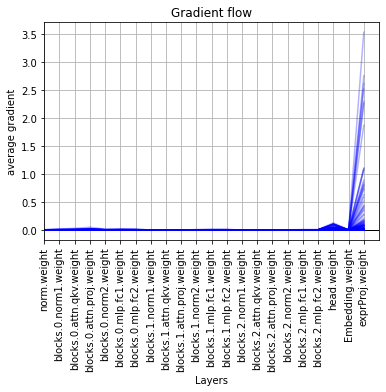

In [54]:
output_dir = './1+128_2pseudo' ### customized your own output_dir
model = vit_tiny()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
model.cuda()
Path(output_dir).mkdir(parents=True, exist_ok=True)
saveckp_freq = 1
to_restore = {"epoch": 0}
utils.restart_from_checkpoint(
    os.path.join(output_dir, "checkpoint.pth"),
    run_variables=to_restore,
    model=model,
    optimizer=optimizer,
)
start_epoch = to_restore["epoch"]
for epoch in range(start_epoch, 150):
    train_one_epoch(train_loader, model, epoch, optimizer)
    # ============ writing logs ... ============
    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch + 1,
    }
    # Train loop
    if epoch % 10 == 0:
      correct, total = 0, 0
    
      with torch.no_grad():
        # Iterate over the test data and generate predictions
          for i, data in enumerate(train_loader, 0):
          # Get inputs
            inputs, targets = data
            inputs = inputs.cuda()
            targets = targets.cuda()
          # Generate outputs
            model.eval()
            outputs = model(inputs)
          # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            # Print accuracy
          train_acc = "%f %%" %(100 * correct / total)
          print(train_acc)
    # Testing loop
      correct, total = 0, 0
      with torch.no_grad():
        # Iterate over the test data and generate predictions
          for i, data in enumerate(test_loader, 0):
          # Get inputs
            inputs, targets = data
            inputs = inputs.cuda()
            targets = targets.cuda()
          # Generate outputs
            model.eval()
            outputs = model(inputs)
          # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        # Print accuracy
          test_acc =  "%f %%" %(100 * correct / total)
          print(test_acc)
      acc_stats = {"Training Accuracy": train_acc, "Testing Accuracy":  test_acc, "epoch": epoch+1}
      with (Path(output_dir) / "acc.txt").open("a") as f: f.write(json.dumps(acc_stats) + "\n")
    utils.save_on_master(save_dict, os.path.join(output_dir, 'checkpoint.pth'))
    if saveckp_freq and epoch % saveckp_freq == 0:
        utils.save_on_master(save_dict, os.path.join(output_dir, f'checkpoint{epoch:04}.pth'))